# Vision Transformer Hands-on by using huggingface libraries (pytorch for fine-tuning)

Reference : https://huggingface.co/blog/fine-tune-vit

## Setup

In [1]:
import torch
from transformers import ViTForImageClassification, ViTImageProcessor, ViTFeatureExtractor, ViTModel

import warnings
warnings.filterwarnings('ignore')

if torch.cuda.is_available():
    torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#model_name = 'google/vit-base-patch16-224'
model_name = 'google/vit-base-patch16-224-in21k'

### Load data

In [2]:
import datasets

datasets.logging.set_verbosity(datasets.logging.ERROR)
dataset = datasets.load_dataset('cifar10')
#dataset = datasets.load_dataset('beans')
dataset

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [3]:
dataset_train_val = dataset['train'].train_test_split(0.2)
#dataset_train = dataset_train_val['train'].select(range(5000))
#dataset_val = dataset_train_val['test'].select(range(1000))
#dataset_test = dataset['test'].select(range(1000))
dataset_train = dataset_train_val['train']
if len(dataset_train) > 10000:
    dataset_train = dataset_train.select(range(10000))
dataset_val = dataset_train_val['test']
if len(dataset_val) > 2000:
    dataset_val = dataset_val.select(range(2000))
dataset_test = dataset['test']
if len(dataset_test) > 2000:
    dataset_test = dataset_test.select(range(2000))


In [4]:
print(dataset_train.features.keys())
image_name = 'image'
label_name = 'labels'
for k in dataset_train.features.keys():
    if k == 'img':
        image_name = k
    if k == 'label':
        label_name = k
print(dataset_train)
print(dataset_val)
print(dataset_test)

print(f'image_name = {image_name}, label_name = {label_name}')

dict_keys(['img', 'label'])
Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})
Dataset({
    features: ['img', 'label'],
    num_rows: 2000
})
Dataset({
    features: ['img', 'label'],
    num_rows: 2000
})
image_name = img, label_name = label


In [5]:
id2label = {i: l for i, l in enumerate(dataset_train.features[label_name].names)}
label2id = {l: i for i, l in id2label.items()}
id2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

## Fine Tuning

In [6]:
from transformers import ViTFeatureExtractor

# ViTImageProcessorと実体は同じ (https://github.com/huggingface/transformers/blob/v4.28.1/src/transformers/models/vit/feature_extraction_vit.py)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
feature_extractor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [7]:
def transform_func(batch_examples):
    inputs = feature_extractor([x for x in batch_examples[image_name]], return_tensors='pt')
    inputs['labels'] = torch.tensor(batch_examples[label_name])
    return inputs

transformed_dataset_train = dataset_train.with_transform(transform_func)
transformed_dataset_val = dataset_val.with_transform(transform_func)
transformed_dataset_test = dataset_test.with_transform(transform_func)
transformed_dataset_train[0:2]

{'pixel_values': tensor([[[[-0.2627, -0.2627, -0.2627,  ..., -0.4902, -0.4902, -0.4902],
          [-0.2627, -0.2627, -0.2627,  ..., -0.4902, -0.4902, -0.4902],
          [-0.2627, -0.2627, -0.2627,  ..., -0.4902, -0.4902, -0.4902],
          ...,
          [-0.5922, -0.5922, -0.5922,  ..., -0.4510, -0.4510, -0.4510],
          [-0.5922, -0.5922, -0.5922,  ..., -0.4510, -0.4510, -0.4510],
          [-0.5922, -0.5922, -0.5922,  ..., -0.4510, -0.4510, -0.4510]],

         [[-0.0275, -0.0275, -0.0275,  ..., -0.2863, -0.2863, -0.2863],
          [-0.0275, -0.0275, -0.0275,  ..., -0.2863, -0.2863, -0.2863],
          [-0.0275, -0.0275, -0.0275,  ..., -0.2863, -0.2863, -0.2863],
          ...,
          [-0.4667, -0.4667, -0.4667,  ..., -0.2471, -0.2471, -0.2471],
          [-0.4667, -0.4667, -0.4667,  ..., -0.2471, -0.2471, -0.2471],
          [-0.4667, -0.4667, -0.4667,  ..., -0.2471, -0.2471, -0.2471]],

         [[-0.4118, -0.4118, -0.4118,  ..., -0.6941, -0.6941, -0.6941],
          [-0

In [8]:
#from transformers.modeling_outputs import BaseModelOutput

class MyModel(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self._model = ViTModel.from_pretrained(model_name, num_labels=len(kwargs['id2label']), id2label=kwargs['id2label'], label2id=kwargs['label2id'])
        self._model.to(device)
        feature_num = self._model.encoder.layer[0].output.dense.out_features
        self._fc = torch.nn.Linear(feature_num, len(id2label))
        self._fc.to(device)

    
    def forward(self, x):
        outputs = self._model(x)
        cls_vec = outputs.last_hidden_state[:, 0, :]
        return self._fc(cls_vec)

model = MyModel(id2label=id2label, label2id=label2id)
model.to(device)

# test before train
test_idx = 0
test_inputs = feature_extractor(images=dataset_test[test_idx][image_name], return_tensors="pt").to(device)
outputs = model.forward(test_inputs.pixel_values)
print(outputs)
idx = outputs.argmax(dim=1).cpu().detach().numpy().tolist()[0]
print(f'Prediced = {idx} : {id2label.get(idx)}')
print(f'Actual = {dataset_test[test_idx][label_name]} : {id2label.get(dataset_test[test_idx][label_name])}')

del test_inputs

tensor([[ 0.0107,  0.0449, -0.0354, -0.0417, -0.1392,  0.0315,  0.0136, -0.0830,
         -0.0148,  0.1794]], device='cuda:0', grad_fn=<AddmmBackward0>)
Prediced = 9 : truck
Actual = 3 : cat


### Train

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
epoch = 4
batch_size = 16
batch_start = 0

# gradient require :only Fully Connected Layer of last layer ?
model.requires_grad_(False)
model._fc.requires_grad_(True)

optimizer = torch.optim.AdamW(params=model._fc.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)
loss_func = torch.nn.CrossEntropyLoss()

train_epochs = []
train_lrs = []

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
log_steps = 100

for i in range(epoch):
    print(f'=== epoch={i} start ===')
    batch_start = 0
    batch_guard_count = 0
    train_loss = 0.0
    predicts = []
    labels = []
    while True:
        # Preprocess (TODO DataLoader for random sampling)
        batch_end = batch_start + batch_size
        if batch_end > len(transformed_dataset_train):
            batch_end = len(transformed_dataset_train)
        batch = transformed_dataset_train[batch_start:batch_end]
        in_data = batch['pixel_values'].to(device)
        label_data = batch['labels'].to(device)

        # Train : predict
        outputs = model.forward(in_data)

        # Train : Loss calc & optimization
        loss = loss_func(outputs, label_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicts += outputs.argmax(dim=1).cpu().detach().numpy().tolist()
        labels += label_data.cpu().detach().numpy().tolist()
        train_loss += loss.item()

        train_epochs.append(batch_end/len(transformed_dataset_train) + i)
        train_lrs.append(optimizer.param_groups[0]['lr'])

        del in_data
        del label_data

        # Set next data range
        batch_start = batch_end
        batch_guard_count += 1
        if batch_end >= len(transformed_dataset_train):
            break

        if batch_guard_count > len(transformed_dataset_train):
            raise Exception(f'Invalid batch loop count {batch_guard_count}')
        
        if batch_guard_count % log_steps == 0:
            accuracy = accuracy_score(labels, predicts)
            print(f'epoch={i}-{batch_guard_count} : accuracy={accuracy}, avg_loss={train_loss/batch_guard_count}')
    
    # Logging
    accuracy = accuracy_score(labels, predicts)

    print(f'=== epoch={i} done : accuracy={accuracy}, loss={train_loss/batch_guard_count}')
    train_losses.append(train_loss/batch_guard_count)
    train_accuracies.append(accuracy) 

    # validation
    val_predicts = []
    val_labels = []
    val_loss = 0.0
    val_batch_count = 0
    for batch_start in range(0, len(transformed_dataset_val), 16):
        batch_end = batch_start + 16
        if batch_end > len(transformed_dataset_val):
            batch_end = len(transformed_dataset_val)
        batch = transformed_dataset_val[batch_start:batch_end]
        in_data = batch['pixel_values'].to(device)
        label_data = batch['labels'].to(device)
        outputs = model.forward(in_data)
        val_loss += loss_func(outputs, label_data).item()
        val_predicts += outputs.argmax(dim=1).cpu().detach().numpy().tolist()
        val_labels += label_data.cpu().detach().numpy().tolist()
        val_batch_count += 1
        del in_data
        del label_data
    val_accuracy = accuracy_score(val_labels, val_predicts)
    val_losses.append(val_loss/val_batch_count)
    val_accuracies.append(val_accuracy)
    print(f'=== epoch={i} validation : accuracy={val_accuracy}, loss={val_loss/val_batch_count}')

    torch.cuda.empty_cache()
    scheduler.step()

=== epoch=0 start ===
epoch=0-100 : accuracy=0.599375, avg_loss=2.0800041270256044
epoch=0-200 : accuracy=0.7553125, avg_loss=1.8593998420238496
epoch=0-300 : accuracy=0.8152083333333333, avg_loss=1.6633917013804118
epoch=0-400 : accuracy=0.84875, avg_loss=1.4955319295823575
epoch=0-500 : accuracy=0.86925, avg_loss=1.3567614068984986
epoch=0-600 : accuracy=0.8828125, avg_loss=1.2412941975394884
=== epoch=0 done : accuracy=0.8866, loss=1.2148175803661347
=== epoch=0 validation : accuracy=0.952, loss=0.59495769405365
=== epoch=1 start ===
epoch=1-100 : accuracy=0.9525, avg_loss=0.5437280306220055
epoch=1-200 : accuracy=0.95, avg_loss=0.5196286731958389
epoch=1-300 : accuracy=0.9504166666666667, avg_loss=0.49430385023355483
epoch=1-400 : accuracy=0.95109375, avg_loss=0.4672631512954831
epoch=1-500 : accuracy=0.952125, avg_loss=0.4447244592308998
epoch=1-600 : accuracy=0.9528125, avg_loss=0.42531299972285824
=== epoch=1 done : accuracy=0.9541, loss=0.4199235842347145
=== epoch=1 validation

In [10]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=3, subplot_titles=['train loss', 'train accuracy', 'train learning rate'])

x = list(range(1, len(train_losses)+1))
colidx = 1
fig.add_trace(go.Scatter(x=x, y=train_losses, name='train_loss'), row=1, col=colidx)
fig.update_xaxes(title="epoch", row=1, col=colidx)
fig.update_yaxes(title="loss", row=1, col=colidx)
colidx += 1
fig.add_trace(go.Scatter(x=x, y=train_accuracies, name='accuracy'), row=1, col=colidx)
fig.update_xaxes(title="epoch", row=1, col=colidx)
fig.update_yaxes(title="accuracy", row=1, col=colidx)
colidx += 1
fig.add_trace(go.Scatter(x=train_epochs, y=train_lrs, name='learning rate'), row=1, col=colidx)
fig.update_xaxes(title="epoch", row=1, col=colidx)
fig.update_yaxes(title="learning rate", row=1, col=colidx)
fig.show()

In [11]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2, subplot_titles=['validation loss', 'validation accuracy'])

x = list(range(1, len(train_losses)+1))
val_batch_count = len(transformed_dataset_val) // 16
fig.add_trace(go.Scatter(x=x, y=val_losses, name='train_loss'), row=1, col=1)
fig.update_xaxes(title="epoch", row=1, col=1)
fig.update_yaxes(title="loss", row=1, col=1)
fig.add_trace(go.Scatter(x=x, y=val_accuracies, name='accuracy'), row=1, col=2)
fig.update_xaxes(title="epoch", row=1, col=2)
fig.update_yaxes(title="accuracy", row=1, col=1)
fig.show()

In [12]:
import os
os.makedirs('./pytorch_train', exist_ok=True)
torch.save(model.state_dict(), './pytorch_train/model.pth')

### Evaluate

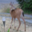

torch.Size([1, 3, 224, 224])
tensor([[-1.1526, -1.4450,  0.2398, -0.6484,  4.8575, -0.6308, -0.9770, -1.6007,
         -1.1498, -1.0120]], device='cuda:0')
Predicted class :  deer
Actual class :  deer


In [13]:
idx = 100
display(dataset_test[idx][image_name])
inputs = feature_extractor(images=dataset_test[idx][image_name], return_tensors="pt").to(device)
pixel_values = inputs.pixel_values
print(pixel_values.shape)
with torch.no_grad():
    output = model.forward(pixel_values)
print(output)
prediction = output.argmax(dim=1)
print("Predicted class : ", id2label[prediction.item()])
print("Actual class : ", id2label[dataset_test[idx][label_name]])

In [14]:
import pandas as pd

result = {'OK': 0, 'NG': 0}
result2 = {}
for idx in range(len(dataset_test)):
    inputs = feature_extractor(images=dataset_test[idx][image_name], return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values
    with torch.no_grad():
        output = model.forward(pixel_values)
    prediction = output.argmax(dim=1)
    true_label = dataset_test[idx][label_name]
    key = 'OK' if prediction.item() == true_label else 'NG'
    result[key] = result[key] + 1
    
    result_per_label = result2.setdefault(id2label[true_label], {})
    result_per_label[key] = result_per_label.setdefault(key, 0) + 1

result_data = {'label': [], 'accuracy': [], 'OK': [], 'NG': [], 'TOTAL': []}
for k, v in result2.items():
    ok = v.get('OK', 0)
    ng = v.get('NG', 0)
    result_data['label'].append(k)
    result_data['accuracy'].append(ok/(ok+ng))
    result_data['OK'].append(ok)
    result_data['NG'].append(ng)
    result_data['TOTAL'].append(ok+ng)
    

total = result['OK'] + result['NG']
result_data['label'].append('all')
result_data['accuracy'].append(result['OK']/(total))
result_data['OK'].append(result['OK'])
result_data['NG'].append(result['NG'])
result_data['TOTAL'].append(total)

df_accuracy = pd.DataFrame(result_data)
df_accuracy

,label,accuracy,OK,NG,TOTAL
0,cat,0.944724,188,11,199
1,ship,0.972350,211,6,217
2,airplane,0.933673,183,13,196
3,frog,0.944444,204,12,216
4,automobile,0.964646,191,7,198
5,truck,0.955665,194,9,203
6,dog,0.956757,177,8,185
7,horse,0.984456,190,3,193
8,deer,0.974747,193,5,198
9,bird,0.974359,190,5,195


## Similarity by Image Feature Vector

In [15]:
#### predict func
from PIL import Image
from IPython.display import Image as ipython_image

def predict_by_trained_model(imgfile):
    display(ipython_image(filename=imgfile, width=150, height=150))
    img = Image.open(imgfile)
    inputs = feature_extractor(images=img, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values
    print(pixel_values.shape)
    with torch.no_grad():
        feature_vector = model._model(pixel_values).last_hidden_state[:, 0, :]
        output = model.forward(pixel_values)
    print(output)
    prediction = output.argmax(dim=1)
    print("Predicted class : ", id2label[prediction.item()])

    return f'{id2label[prediction.item()]}-{imgfile}', id2label[prediction.item()], feature_vector

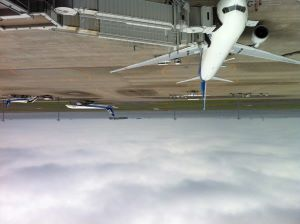

torch.Size([1, 3, 224, 224])
tensor([[ 4.5417, -1.1340, -0.5534, -0.7441, -0.0561, -0.6750, -0.0235, -1.2442,
         -1.4094, -0.2453]], device='cuda:0')
Predicted class :  airplane


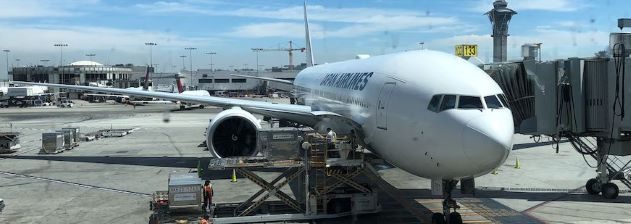

torch.Size([1, 3, 224, 224])
tensor([[ 3.8050, -1.5240, -0.1252, -0.8404, -0.1809, -0.9809, -0.2942, -0.8589,
         -0.5290,  0.0946]], device='cuda:0')
Predicted class :  airplane


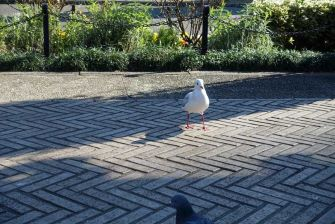

torch.Size([1, 3, 224, 224])
tensor([[-0.3590, -0.9898,  1.8454, -0.2442,  0.1670, -0.8510,  0.2429, -0.1707,
         -0.3225, -0.0204]], device='cuda:0')
Predicted class :  bird


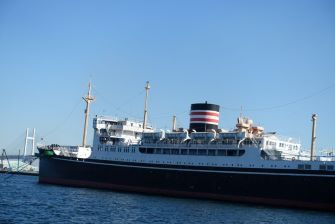

torch.Size([1, 3, 224, 224])
tensor([[-0.8937, -0.4289, -0.1881, -1.0522, -0.5111, -0.5720, -0.6441, -0.4643,
          3.6261,  0.0932]], device='cuda:0')
Predicted class :  ship


In [19]:
import glob
files = glob.glob('testdata/*')
jpg_files = [f for f in files if f.lower().endswith('jpg')]

feature_vectors = {}
feature_labels = {}
for f in jpg_files:
    k, label, v = predict_by_trained_model(f)
    feature_vectors[k] = v
    feature_labels[k] = label

In [20]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=2)

names = []
labels = []
values = []
for k, v in feature_vectors.items(): 
    names.append(k)
    labels.append(feature_labels.get(k))
    values.append(v.cpu().numpy()[0])

df_samples = pd.DataFrame({'name': names, 'label': labels})
df_samples[['PCA1', 'PCA2']] = pca.fit_transform(np.array(values))
df_samples


,name,label,PCA1,PCA2
0,airplane-testdata\test11.jpg,airplane,-2.285337,-1.323485
1,airplane-testdata\test22_background.jpg,airplane,-2.173894,-0.864092
2,bird-testdata\test33.jpg,bird,4.122936,-1.489112
3,ship-testdata\test44.jpg,ship,0.336297,3.676688


In [23]:
import plotly.graph_objects as go

fig = go.Figure()

for l in df_samples['label'].unique().tolist():
    df_tmp = df_samples[df_samples['label'] == l]
    fig.add_trace(go.Scatter(x=df_tmp['PCA1'], y=df_tmp['PCA2'], name=l, mode='markers'))
fig.update_layout(title='last_hidden_state decomposition vector plot', width=500, height=400)
fig.update_xaxes(title='PCA1')
fig.update_yaxes(title='PCA2')
fig.show()